In [20]:
DATA_FOLDER = "datathon_SC_ACN_22/"
SEP = ";"

In [21]:
import pandas as pd

# ports that are the same but have different names (data cleaning)
same_ports =  {
    'ATHENAS': 'Athens',
    'BCN': 'Barcelona',
}

# converters function for pd.read_csv()
convs = {
    'origin_port': lambda x: same_ports[x] if x in same_ports else x
}

df_cities = pd.read_csv(DATA_FOLDER + "cities_data.csv", sep=SEP)
df_cities_costs = pd.read_csv(DATA_FOLDER + "cities_data_costs.csv", sep=",")
df_orders = pd.read_csv(
  DATA_FOLDER + "orders.csv",
  sep=SEP,
  na_filter=False,
  converters=convs)
df_product_attr = pd.read_csv(DATA_FOLDER + "product_attributes.csv", sep=",")
df_product_weight_class = pd.read_csv(DATA_FOLDER + "product_weight_class.csv", sep=",")
df_test = pd.read_csv(
  DATA_FOLDER + "test.csv",
  sep=SEP,
  na_filter=False,
  converters=convs)
print(df_orders.shape, df_test.shape, df_cities.shape, df_cities_costs.shape, df_product_attr.shape, df_product_weight_class.shape)

def join_with_product_attr(df, mean_weight=None):
  # the inner merge operation would get rid of orders that have product_id -1
  df_out = df.merge(df_product_attr, on="product_id", how="left")

  # fill NaN values
  df_out["material_handling"] = df_out["material_handling"].fillna(-1)

  # use mean of weights for missing weights
  if mean_weight is None:
    mean_weight = df_out["weight"].mean()
  df_out["weight"] = df_out["weight"].fillna(mean_weight)

  # multiply units with weight, giving total weight
  df_out["total_weight"] = df_out["units"] * df_out["weight"]

  return df_out, mean_weight

# join order data with product attributes
df_orders, mean_weight = join_with_product_attr(df_orders)
df_test, _ = join_with_product_attr(df_test, mean_weight)

print(df_orders.shape, df_test.shape)

# sort values of test dataset, which will help later with creating the datasets for ML
df_orders.sort_values("late_order", inplace=True, ignore_index=True)

(114276, 9) (28563, 8) (666, 5) (6660, 8) (772, 3) (772, 2)
(114276, 12) (28563, 11)


In [4]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def make_discrete_features(df, discrete_cols, enc, fit):
  discrete_raw_features = df[discrete_cols]
  if fit:
    enc.fit(discrete_raw_features)
  discrete_features = np.array(enc.transform(discrete_raw_features).toarray())
  return discrete_features, enc

one_hot_features, enc = make_discrete_features(
  df_orders,
  [
    "origin_port",
    "3pl",
    "customs_procedures",
    "logistic_hub",
    "customer",
    "product_id",
  ],
  OneHotEncoder(),
  fit=True)

# scale the unit values
unscaled_units = df_orders["units"].to_numpy()[:, np.newaxis]
scaler = MinMaxScaler()
scaler.fit(unscaled_units)
units_scaled = scaler.transform(unscaled_units)
# print(units_scaled)

# scale the total_weight values
unscaled_total_weight = df_orders["total_weight"].to_numpy()[:, np.newaxis]
scaler = MinMaxScaler()
scaler.fit(unscaled_total_weight)
total_weight_scaled = scaler.transform(unscaled_total_weight)

raw_X = np.concatenate([one_hot_features, units_scaled, total_weight_scaled], axis=1) 
raw_y = df_orders["late_order"]
# print(raw_X)
print("Feature size:", raw_X.shape)

Feature size: (114276, 820)


In [5]:
### Balance out features and targets

# count amount of negatives
num_positives = sum(raw_y)
num_negatives = len(raw_y) - num_positives

assert sum(raw_y[:num_negatives]) == 0
assert sum(raw_y[num_negatives:]) == num_positives

print(len(raw_y), "total")
print({
  "0": num_negatives,
  "1": num_positives
}, "->", num_negatives / len(raw_y), "negative")

# select negative features
perm = np.random.permutation(num_negatives)
negative_X = raw_X[perm[:num_positives*2]]
negative_y = raw_y[perm[:num_positives*2]]

# select positive features
positive_X = raw_X[num_negatives:]
positive_y = raw_y[num_negatives:]

# concatenate features
X = np.concatenate((negative_X, positive_X, positive_X), axis=0)
y = np.concatenate((negative_y, positive_y, positive_y), axis=0)
print("X:", X.shape, "y:", y.shape)
print("ratio:", sum(y) / len(y))

# shuffle datasets
shuffle_perm = np.random.permutation(len(X))
X = X[shuffle_perm]
y = y[shuffle_perm]

split = (len(y) * 7) // 10
print("split at", split)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

114276 total
{'0': 87120, '1': 27156} -> 0.7623648010080857 negative
X: (108624, 820) y: (108624,)
ratio: 0.5
split at 76036


In [10]:
### Train models
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# svm_model = SVC(gamma="auto")
# svm_model.fit(X_train, y_train)

tree_model = tree.DecisionTreeClassifier()
# TODO: adjust data for tree and output tree
# X_train_tree = np.concatenate([
#   enc.inverse_transform(X_train[:, :-1]),
#   X_train[:, -1:]], axis=1)

# X_test_tree = np.concatenate([
#   enc.inverse_transform(X_test[:, :-1]),
#   X_test[:, -1:]], axis=1)
tree_model.fit(X_train, y_train)

# log_model = LogisticRegression(solver="sag")
# log_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

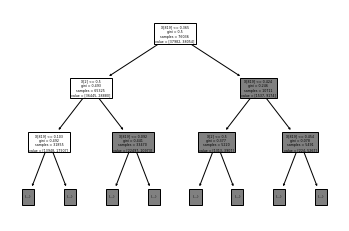

In [19]:
import matplotlib.pyplot as plt

tree.plot_tree(tree_model, max_depth=2)
plt.savefig("test.svg", format="svg", fontsize=11)
plt.show()

In [7]:
# evaluate the approaches
def eval_model(pred_fn, name):
  pred = pred_fn(X_test)
  print("pred", pred)
  print("pred ratio", sum(pred) / len(X_test))
  hits = sum([1 if y_hat == y else 0 for (y_hat, y) in zip(pred, y_test) ])
  print(name, "acc:", hits / len(pred))

# eval_model(svm_model.predict, "svm")

eval_model(tree_model.predict, "tree")
# simple: 0.80

eval_model(log_model.predict, "log")
# simple: 0.75



pred [ True  True  True ...  True  True  True]
pred ratio 0.5652080520436971
tree acc: 0.8111881674235915
pred [ True False  True ...  True  True  True]
pred ratio 0.4878482877132687
log acc: 0.7484963790352277


In [8]:
# make features with testing data
one_hot_features, _ = make_discrete_features(
  df_test,
  [
    "origin_port",
    "3pl",
    "customs_procedures",
    "logistic_hub",
    "customer",
    "product_id",
  ],
  enc,
  fit=False)

# scale the unit values
unscaled_units = df_test["units"].to_numpy()[:, np.newaxis]
units_scaled = scaler.transform(unscaled_units)

# scale the unit values
unscaled_total_weight = df_test["total_weight"].to_numpy()[:, np.newaxis]
total_weight_scaled = scaler.transform(unscaled_total_weight)

X_eval = np.concatenate([one_hot_features, units_scaled, total_weight_scaled], axis=1) 
print("Feature size:", X_eval.shape)

# evaluate test cases
probs = log_model.predict_proba(X_eval)
print(probs)

# print probabilities
submission = pd.DataFrame({"order_id": df_test.order_id, "late_order": probs[:,1]})
submission.to_csv("submission/submission_kaggle_test.csv", index=False)

Feature size: (28563, 820)
[[0.90244219 0.09755781]
 [0.90158268 0.09841732]
 [0.77153897 0.22846103]
 ...
 [0.84886028 0.15113972]
 [0.4377506  0.5622494 ]
 [0.7347803  0.2652197 ]]
